# Reader+batching+coordinator = Reading data

In [50]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [51]:
"""
먼저 가장 간단하게 MNIST를 불러와보자
"""
from tensorflow.examples.tutorials.mnist import input_data
data=input_data.read_data_sets("./",one_hot=True)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
<class 'tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet'>
<class 'numpy.ndarray'>
(55000, 784)
(55000, 10)


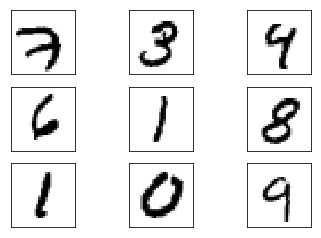

In [57]:
print(type(data))   
print(type(data.train))   #이 두개는 뭔지 모르는 타입이다, 그냥 두자 
print(type(data.train.images))  #numpy array이다.
print((data.train.images).shape)
print(data.train.labels.shape)  #numpy에서 shape은 괄호 안친다.
"""
위의 쉐잎에서 이 방법은 모든 데이터를 메모리에 올린다는 것을 알 수 있다.
앞의 데이터 9개를 한번 보도록 하자
"""
images=data.train.images
fig, axes = plt.subplots(3, 3)
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].reshape([28,28]), cmap='binary')
    ax.set_xticks([])
    ax.set_yticks([])

In [69]:
"""
이제 queue를 이용하여 데이터를 불러올 것이다.
1.어떤 파일에서 데이터를 불러올 것인지를 명시한다, MNIST는 이미지파일,라벨파일이 나누어져있다. 그래서 두개를 써준다.
2.어떤 리더기로 데이터를 읽어올 것인지를 명시한다, MNIST,CIFAR 같은 데이터셋은 보통 바이너리화 된 데이터파일이다, 그래서 FixedLengthRecordReader를 써준다.
tip:http://yann.lecun.com/exdb/mnist/ 여기에 가면 이 데이터파일에 대한 구성정보가 나와있다, 예를 들어 이미지파일은 헤더가 16바이트 있다고한다.
->header_bytes=16
3.리더기와 파일목록을 연결시켜준다. (key,value)를 리턴하는데 key는 이 설정대로 읽었을 때 몇번째 데이터인지를 나타낸다, value는 데이터의 구체적인 정보
4.binary데이터를 읽은 것이기에 이걸 디코드해주어야한다, 8비트씩 묶어주면 된다.
"""
def __read_cifar(filenames, shuffle=False, cifar100=False):
  """Reads and parses examples from MNIST data files."""
  filename_queue_image = tf.train.string_input_producer(filenames[0], shuffle=shuffle,num_epochs=None)
  filename_queue_label = tf.train.string_input_producer(filenames[1], shuffle=shuffle,num_epochs=None)
  label_bytes = 1
  height = 28
  width = 28
  depth = 1
  image_bytes = height * width * depth
  reader_image = tf.FixedLengthRecordReader(record_bytes=image_bytes,header_bytes=16)
  reader_label = tf.FixedLengthRecordReader(record_bytes=label_bytes,header_bytes=8)
  key_image, value_image = reader_image.read(filename_queue_image)
  key_label, value_label = reader_label.read(filename_queue_label)

  # Convert from a string to a vector of uint8 that is record_bytes long.
  record_bytes_image= tf.decode_raw(value_image, tf.uint8)
  record_bytes_label = tf.decode_raw(value_label, tf.uint8)

  # The first bytes represent the label, which we convert from uint8->int32.
  # The remaining bytes after the label represent the image, which we reshape
  # from [depth * height * width] to [depth, height, width].
    
    
  depth_major = tf.reshape(tf.slice(record_bytes_image, [0], [image_bytes]),  #def slice(input_, begin, size, name=None):
                           [depth, height, width])
  label = tf.cast(tf.slice(record_bytes_label, [0], [label_bytes]), tf.int32)

  image = tf.transpose(depth_major, [1, 2, 0])

  return tf.cast(image, tf.float32),label,key_image,key_label
# image=__read_cifar(['./train-images.idx3-ubyte'])


In [62]:
"""
5.여기서는 batching을 해준다, 이걸 안해주더라도 데이터를 읽을 수는 있다.
"""
class DataProvider:
    def __init__(self, data, size=None, training=True):
        self.size = size or [None]*4
        self.data = data
        self.training = training

    def next_batch(self, batch_size, min_queue_examples=1000, num_threads=8):
        """Construct a queued batch of images and labels.

        Args:
        image: 3-D Tensor of [height, width, 3] of type.float32.
        label: 1-D Tensor of type.int32
        min_queue_examples: int32, minimum number of samples to retain
        in the queue that provides of batches of examples.
        batch_size: Number of images per batch.

        Returns:
        images: Images. 4D tensor of [batch_size, height, width, 3] size.
        labels: Labels. 1D tensor of [batch_size] size.
        """
        # Create a queue that shuffles the examples, and then
        # read 'batch_size' images + labels from the example queue.

        image, label,key_image,key_label = self.data
        if self.training:
            images, label_batch,key_images,key_labels = tf.train.shuffle_batch(
            [image, label,key_image,key_label],
            batch_size=batch_size,
            num_threads=8,
            capacity=min_queue_examples + 3 * batch_size,
            min_after_dequeue=min_queue_examples)
        else:
            images, label_batch = tf.train.batch(
            [preprocess_evaluation(image, height=self.size[1], width=self.size[2]), label],
            batch_size=batch_size,
            num_threads=num_threads,
            capacity=min_queue_examples + 3 * batch_size)

        return images, tf.reshape(label_batch, [batch_size]),key_images,key_labels

In [64]:
a=DataProvider(__read_cifar([['./train-images.idx3-ubyte'],['./train-labels.idx1-ubyte']]), [50000, 28,28,1], True)

In [70]:
b,c,d,e=a.next_batch(1)
print(b,c)
print(d,e)

Tensor("shuffle_batch_1:0", shape=(1, 28, 28, 1), dtype=float32) Tensor("Reshape_50:0", shape=(1,), dtype=int32)
Tensor("shuffle_batch_1:2", shape=(1,), dtype=string) Tensor("shuffle_batch_1:3", shape=(1,), dtype=string)


In [80]:
"""
Coordinator가 꼭 필요하다, 위에서 나온건 겉으로 보기에는 멀쩡해보이지만 조정담당이 없으면 데이터를 한개도!! 뱉어내지 못한다.
"""
sess=tf.InteractiveSession()
coord=tf.train.Coordinator()
threads=tf.train.start_queue_runners(sess=sess,coord=coord)


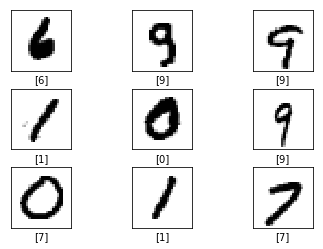

In [81]:
examples_img,examples_label=[],[]
for i in range(9):
    temp_img,temp_label=sess.run([tf.reshape(b,shape=[28,28]),c])
    examples_img.append(temp_img)
    examples_label.append(temp_label)

fig, axes = plt.subplots(3, 3)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, ax in enumerate(axes.flat):
    ax.imshow(examples_img[i].reshape([28,28]), cmap='binary')
    ax.set_xlabel(str(examples_label[i]))
    ax.set_xticks([])
    ax.set_yticks([])

In [79]:
coord.request_stop()
coord.join(threads)
coord.clear_stop()
sess.close()



"""
2)coordinator없이 데이터 읽으려고 함
3)헤더 지정 안해줌
4)label하고 이미지하고 다른현상,sess.run
5)subplot
6)gz file자동압축해제 안되는 현상
"""